(sec:ml)=
# Machine learning

[PyTorch](https://en.wikipedia.org/wiki/PyTorch) is an open source machine learning (ML) framework based on the Python programming language and the Torch library. 

In [1]:
import torch
import torchvision

In [2]:
import matplotlib.pyplot as plt
import numpy as np

PyTorch offers domain-specific libraries such as `TorchText`, `TorchVision`, and `TorchAudio`, all of which include datasets. We will use a TorchVision dataset named MNIST.

## Data set

The [MNIST data set](https://en.wikipedia.org/wiki/MNIST_database) consists of 28 x 28 pixel greyscale images of handwritten digits, along with labels for each image indicating which digit it represents. The data set has 60,000 images. 

![MNIST handwritten numbers](../images/MnistExamplesModified.png)

### Loading dataset

In [3]:
mnist_dataset = torchvision.datasets.MNIST(
    root="../data_input/",
    download=True,
    train=True,
    transform=torchvision.transforms.ToTensor(),
)
print(mnist_dataset)

100%|███████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 10397665.77it/s]


Extracting ../data_input/MNIST/raw/train-images-idx3-ubyte.gz to ../data_input/MNIST/raw



100%|███████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 31204454.87it/s]


Extracting ../data_input/MNIST/raw/train-labels-idx1-ubyte.gz to ../data_input/MNIST/raw



100%|████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 9628727.64it/s]


Extracting ../data_input/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data_input/MNIST/raw



100%|██████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 9906671.23it/s]

Extracting ../data_input/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data_input/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data_input/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [4]:
idx_random_tensor = np.random.randint(60000)

In [5]:
image, label = mnist_dataset[idx_random_tensor]

print("Label:", label)
print("Dataset item:", idx_random_tensor)
print("Tensor shape:", image.shape)

Label: 2
Dataset item: 12352
Tensor shape: torch.Size([1, 28, 28])


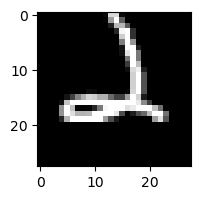

In [6]:
fig = plt.figure(figsize=(2,2))
plt.imshow(image[0, :, :], cmap="gray")
plt.show()

### Split data set into subsets

In machine learning, [data sets are typically divided into the three categories](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets) of training, validation, and test. We will divide data into two categories and skip the model tuning in the validation step. 

In [7]:
training_data, test_data = torch.utils.data.random_split(mnist_dataset, [50000, 10000])

We create data loaders to be able to load the data in batches. 

The shuffle option is set for the training data loader, so that the batches generated in each epoch are different. As the validation data loader is used only for evaluating the model, there is no need to shuffle these data.

In [8]:
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False)

## Neural network model

### Setting up the model

In [9]:
class MnistModel(torch.nn.Module):

    input_layer_dim = 28 * 28
    hidden_layer_dim = 512
    number_classes = 10

    def __init__(self):
        super().__init__()

        self.linear_stack = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(self.input_layer_dim, self.hidden_layer_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden_layer_dim, self.hidden_layer_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden_layer_dim, self.number_classes),
        )

    def forward(self, x):
        y = self.linear_stack(x)
        return y

In [10]:
model = MnistModel()

In [11]:
print(model)

MnistModel(
  (linear_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Model assessment

A loss function is defined to quantify the model output from the reference. 

In [12]:
loss_func = torch.nn.CrossEntropyLoss()

With this loss function, we determine the averaged loss and the percentage of correct predictions.

In [13]:
def test(dataloader, model):

    model.eval()

    number_correct = 0
    with torch.no_grad():
        for images, labels in dataloader:  # batches of images and labels
            output = model(images)
            number_correct += (
                (output.argmax(1) == labels).type(torch.float).sum().item()
            )

    size = len(dataloader.dataset)  # size is 10,000 in our case
    accuracy = 100 * number_correct / size  # in percent

    return accuracy

### Initial model performance

With random parameters, we expect to prediction success of about 10%.

In [14]:
accuracy = test(test_dataloader, model)

print(f"Accuracy: {accuracy:>0.1f}%")

prediction_accuracies = [accuracy]  # saved in list for plotting

Accuracy: 7.8%


### Model training

In [15]:
number_of_epochs = 2  # number of iterations in the training

learning_rate = 0.01  # step length in gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [16]:
def train(dataloader, model, loss_func, optimizer):

    for images, labels in dataloader:  # batches of images and labels

        output = model(images)
        loss = loss_func(output, labels)

        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [17]:
for epoch in range(number_of_epochs):

    print(f"Epoch ({epoch+1}/{number_of_epochs}):")

    train(train_dataloader, model, loss_func, optimizer)

    accuracy = test(test_dataloader, model)    
    prediction_accuracies.append(accuracy)

    print(f"  accuracy: {accuracy}%")

Epoch (1/2):
  accuracy: 80.66%
Epoch (2/2):
  accuracy: 87.48%


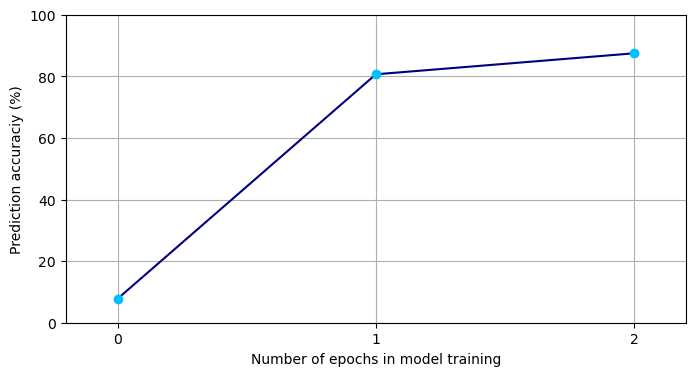

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(prediction_accuracies, "-", color="navy")
ax.plot(prediction_accuracies, "o", color="deepskyblue")

ax.set_xticks(range(0, number_of_epochs + 1))
ax.set_ylim((0, 100))
ax.set_xlim((-0.2, number_of_epochs + 0.2))
ax.grid(True)

ax.set_xlabel("Number of epochs in model training")
ax.set_ylabel("Prediction accuraciy (%)")

plt.show()

## Single image prediction

In [19]:
def predict_image(x, model):

    y = model(x)

    _, prediction = torch.max(y, dim=1)

    return prediction[0].item()

In [20]:
idx_random_tensor = np.random.randint(10000)

Test data set item: 8442
Label: 1
Predicted : 1


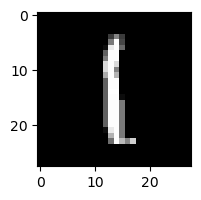

In [21]:
image, label = test_data[idx_random_tensor]

print("Test data set item:", idx_random_tensor)
print("Label:", label)
print("Predicted :", predict_image(image, model))

fig = plt.figure(figsize=(2,2))
plt.imshow(image[0, :, :], cmap="gray")
plt.show()

## Saving and loading models

The model parameters (weights and biases) are returned by the `state_dict()` method.

The model parameters can be saved to a file.

In [22]:
# torch.save(model.state_dict(), "mnist-model.pth")

A saved model can be read from file.

In [23]:
# model = MnistModel()
# model.load_state_dict(torch.load("mnist-model.pth"))

## YouTube material

If you choose a project in the category of machine learning, it is *highly* recommended (close to mandatory) that you also take the time to watch the series of four videos on neural networks from the (generally) excellent channel [3Blue1Brown](https://www.youtube.com/@3blue1brown).

In [24]:
from IPython.display import YouTubeVideo

YouTubeVideo("aircAruvnKk?si=p7eKKqYI8u8mqfIb")

## Forming your project

### Data representation in the input layer

In the case of images, it is rather obvious how to represent the input data in the input layer namely by associating neurons to the bits in the images.

In other cases, it may be less obvious. How do we e.g. represent molecules and how can we get an objective measure of closeness  of chemical structures? In answer to these questions, molecular fingerprints have been developed.

In [25]:
YouTubeVideo("kBk8HbjWwCw?si=3yspJyCsgnBynzT0")

### Machine Learning-Guided Protein Engineering

Find inspiration for using machine learning in protein engineering in the perspective article below. The authors provide an overview of ongoing trends in this domain, highlight recent case studies, and examine the current limitations of machine learning-based methods. They present their opinions on the fundamental problems and outline the potential directions for future research.

```{image} ../images/ml_protein.jpeg
:alt: ML and proteins
:class: bg-primary mb-1
:width: 400px
:align: left
```

*ACS Catalysis* **2023**, 13, 21, 13863–13895, [https://doi.org/10.1021/acscatal.3c02743](https://doi.org/10.1021/acscatal.3c02743)